In [6]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator, DayLocator, MONDAY
import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

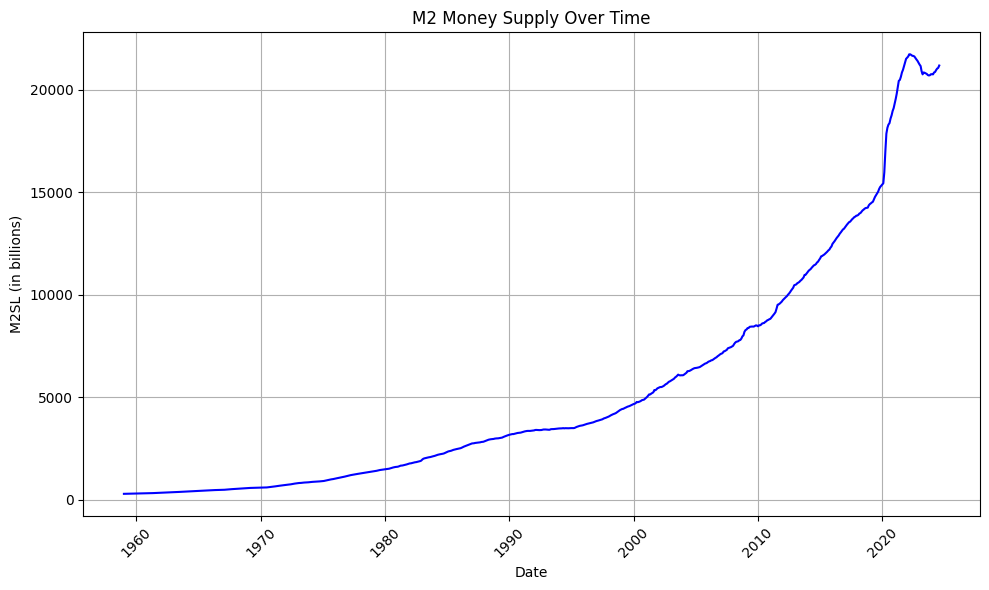

In [7]:
#Get the data and plot it
data = pd.read_csv("data/M2SL.csv")
data['DATE'] = pd.to_datetime(data['DATE'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['M2SL'], linestyle='-', color='b')
plt.title('M2 Money Supply Over Time')
plt.xlabel('Date')
plt.ylabel('M2SL (in billions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
def pandas_candlestick_ohlc(dat, stick="day", otherseries=None, txt=""):
    """
    Japanese candlestick chart showing OHLC prices for a specified time period
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
    :param txt: Title text for the candlestick chart

    :returns: a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    sns.set(rc={'figure.figsize':(20, 10)})
    sns.set_style("whitegrid")  # Apply seaborn whitegrid style to the plots 

    transdat = dat.loc[:, ["Open", "High", "Low", "Close"]].copy()

    if type(stick) == str and stick in ["day", "week", "month", "year"]:
        if stick != "day":
            if stick == "week":
                transdat['period'] = pd.to_datetime(transdat.index).map(lambda x: x.strftime('%Y-%U'))
            elif stick == "month":
                transdat['period'] = pd.to_datetime(transdat.index).map(lambda x: x.strftime('%Y-%m'))
            elif stick == "year":
                transdat['period'] = pd.to_datetime(transdat.index).map(lambda x: x.strftime('%Y'))
            
            grouped = transdat.groupby('period')
            plotdat = pd.DataFrame([{
                "Open": group.iloc[0]["Open"],
                "High": max(group["High"]),
                "Low": min(group["Low"]),
                "Close": group.iloc[-1]["Close"]
            } for _, group in grouped], index=pd.to_datetime([period for period, _ in grouped]))
        else:
            plotdat = transdat
            plotdat['period'] = pd.to_datetime(plotdat.index)
    elif type(stick) == int and stick >= 1:
        transdat['period'] = np.floor(np.arange(len(transdat)) / stick)
        grouped = transdat.groupby('period')
        plotdat = pd.DataFrame([{
            "Open": group.iloc[0]["Open"],
            "High": max(group["High"]),
            "Low": min(group["Low"]),
            "Close": group.iloc[-1]["Close"]
        } for _, group in grouped], index=[group.index[0] for _, group in grouped])
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')

    plotdat['date_num'] = date2num(plotdat.index.to_pydatetime())

    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(20, 10)})
    candlestick_ohlc(ax, plotdat[['date_num', 'Open', 'High', 'Low', 'Close']].values, width=0.6/(24*60), colorup='g', colordown='r')

    if otherseries is not None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        for series in otherseries:
            dat[series].plot(ax=ax, lw=1.3)

    plt.title(f"Candlestick chart of HSBA.L OHLC stock prices from 01 Jan 2014 - 31 Dec 2023", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    candlestick_ohlc(ax, plotdat[['date_num', 'Open', 'High', 'Low', 'Close']].values, width=20, colorup='g', colordown='r')

    plt.show()

In [9]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="5y")
print(sp500.head())

                                  Open         High          Low        Close  \
Date                                                                            
2019-10-15 00:00:00-04:00  2973.610107  3003.280029  2973.610107  2995.679932   
2019-10-16 00:00:00-04:00  2989.679932  2997.540039  2985.199951  2989.689941   
2019-10-17 00:00:00-04:00  3000.770020  3008.290039  2991.790039  2997.949951   
2019-10-18 00:00:00-04:00  2996.840088  3000.000000  2976.310059  2986.199951   
2019-10-21 00:00:00-04:00  2996.479980  3007.330078  2995.350098  3006.719971   

                               Volume  Dividends  Stock Splits  
Date                                                            
2019-10-15 00:00:00-04:00  3345090000        0.0           0.0  
2019-10-16 00:00:00-04:00  3230320000        0.0           0.0  
2019-10-17 00:00:00-04:00  3103470000        0.0           0.0  
2019-10-18 00:00:00-04:00  3268970000        0.0           0.0  
2019-10-21 00:00:00-04:00  3271960000     

[*********************100%***********************]  1 of 1 completed

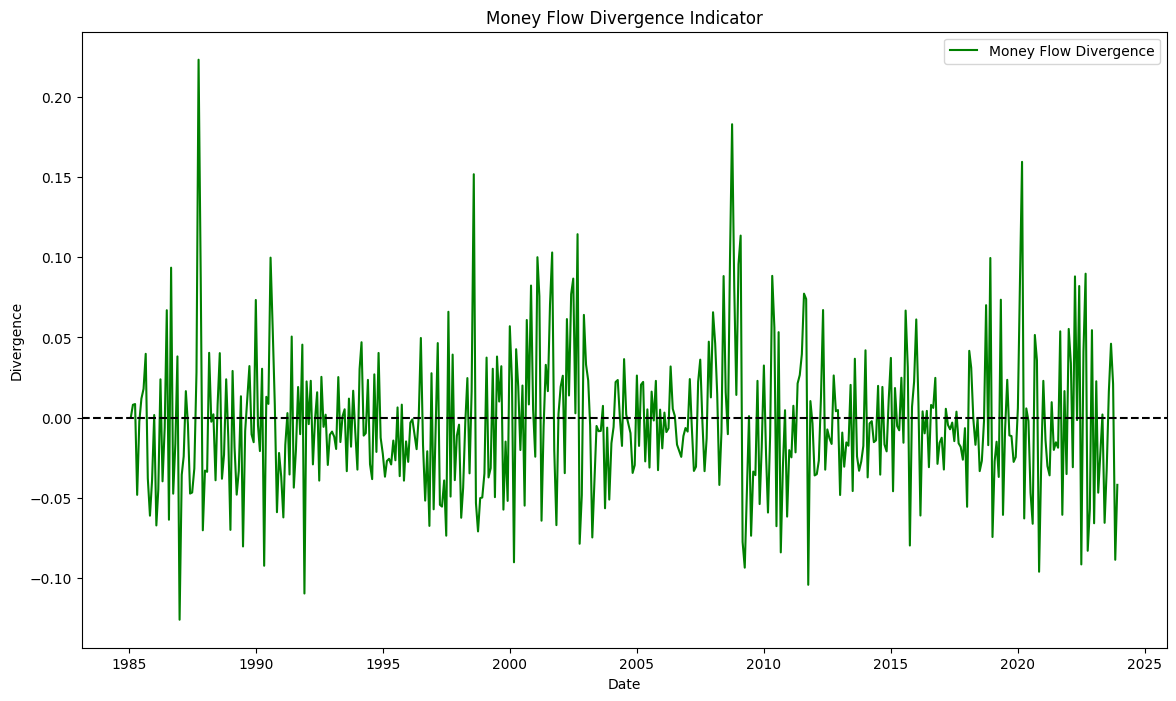

Buy Signals:           DATE  Growth Divergence
330 1986-07-01           0.066975
332 1986-09-01           0.093487
345 1987-10-01           0.223096
346 1987-11-01           0.086805
372 1990-01-01           0.073353
379 1990-08-01           0.099741
380 1990-09-01           0.055071
389 1991-06-01           0.050555
463 1997-08-01           0.066003
475 1998-08-01           0.151720
492 2000-01-01           0.056984
500 2000-09-01           0.060893
502 2000-11-01           0.082348
505 2001-02-01           0.100008
506 2001-03-01           0.075752
511 2001-08-01           0.070604
512 2001-09-01           0.102956
519 2002-04-01           0.061454
521 2002-06-01           0.076983
522 2002-07-01           0.086685
524 2002-09-01           0.114357
527 2002-12-01           0.064054
588 2008-01-01           0.065701
593 2008-06-01           0.088258
596 2008-09-01           0.099687
597 2008-10-01           0.182886
598 2008-11-01           0.081189
600 2009-01-01           0.095618
6

In [21]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Get the data

# Download S&P 500 data using yfinance
sp500 = yf.download('^GSPC', start='1970-01-01', end='2024-01-01', interval='1mo')

m2_data = pd.read_csv('data/M2SL.csv', parse_dates=['DATE'])

# Calculate monthly growth rates for S&P 500
sp500['SP500 Growth'] = sp500['Adj Close'].pct_change()
m2_data['M2 Growth'] = m2_data['M2SL'].pct_change()

# Step 3: Merge the data on date
# Ensure both datasets have the same frequency and are aligned by date
merged_data = pd.merge(sp500[['Adj Close', 'SP500 Growth']], m2_data[['DATE', 'M2SL', 'M2 Growth']], left_index=True, right_on='DATE')

# Step 4: Calculate Money Flow Divergence
merged_data['Growth Divergence'] = merged_data['M2 Growth'] - merged_data['SP500 Growth']

# Step 5: Visualize the indicator
plt.figure(figsize=(14, 8))
plt.plot(merged_data['DATE'], merged_data['Growth Divergence'], label='Money Flow Divergence', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Money Flow Divergence Indicator')
plt.xlabel('Date')
plt.ylabel('Divergence')
plt.legend()
plt.show()

# Step 6: Strategy - Buy when divergence is greater than 5%
buy_signals = merged_data[merged_data['Growth Divergence'] > 0.05]
print(f"Buy Signals: {buy_signals[['DATE', 'Growth Divergence']]}")
